In [3]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Function to run experiment and extract accuracy & epsilon
def run_experiment(dataset, feature_aware=False, dp_ppr=False, dp_sgd=False,gravity = False,heat = False, topk = 2,sigma_values=0):
    print(f"Running experiment with data_file={dataset}")
    
    command = [
        "python", "main.py",
        f"--data_file={dataset}",
        f"--feature_aware={feature_aware}",
        f"--dp_ppr={dp_ppr}",
        f"--dp_sgd={dp_sgd}",
        f"--sigma_ista={sigma_values}",
        f"--gravity={gravity}",
        f"--heat={heat}",
        f"--topk={topk}"
    ]
    
    try:
        result = subprocess.run(
            command, capture_output=True, text=True, encoding='utf-8', check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"Error running the command: {e}")
        print(f"Standard Output:\n{e.stdout}")
        print(f"Standard Error:\n{e.stderr}")
        return None, None

    output = result.stdout
    error_output = result.stderr

    print(output)
    
    accuracy, epsilon = None, None
    for line in output.splitlines()[-10:]:  # Look at last 10 lines
        if "Testing accuracy" in line:
            try:
                accuracy = float(line.split(":")[1].strip())
            except ValueError:
                accuracy = None
        if "Epsilon" in line:
            try:
                epsilon = float(line.split(":")[1].strip())
            except ValueError:
                epsilon = None
    
    return accuracy, epsilon

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.20s
Finish Load Data.

No DP for calculating PPR
No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.14s
Training starts ... 
Training finished.
Testing accuracy: 0.6935
Epsilon :  0

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.16s
Finish Load Data.

No DP for calculating PPR
No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.10s
Training starts ... 
Training finished.
Testing accuracy: 0.6873
Epsilon :  0

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.16s
Finish Load

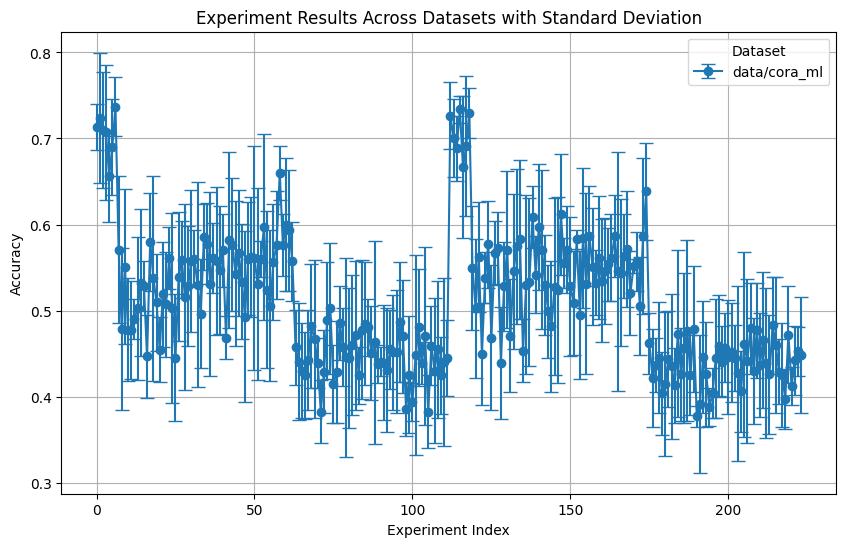

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Settings
datasets = ["data/cora_ml"]
dp_ppr_setting = [False, True, False, True, False, True, False, True]
dp_sgd_setting = [False, False, True, True, False, False, True, True]
feature_aware_setting = [False, False, False, False, True, True, True, True]
sigma_values = [0.15082, 0.08104, 0.05619, 0.04326, 0.03526, 0.02983, 0.02590]
num_runs = 5  # Run each experiment 5 times
topk_values = range(2, 9)  # Running experiments for topk from 2 to 8

# Collect results
results = []
for dataset in datasets:
    for i in range(len(dp_ppr_setting)):
        for topk in topk_values:  # Loop over topk values
            if dp_ppr_setting[i]:  # If DP-PPR is True, run for all sigma values
                for sigma in sigma_values:
                    acc_vals, eps_vals = [], []
                    for _ in range(num_runs):
                        accuracy, epsilon = run_experiment(
                            dataset, dp_ppr=True, dp_sgd=dp_sgd_setting[i], 
                            feature_aware=feature_aware_setting[i], sigma_values=sigma, topk=topk
                        )
                        acc_vals.append(accuracy)
                        eps_vals.append(epsilon)
                    
                    results.append((dataset, True, dp_sgd_setting[i], feature_aware_setting[i], 
                                    sigma, topk,
                                    sum(acc_vals) / num_runs,  # Mean Accuracy
                                    sum(eps_vals) / num_runs,  # Mean Epsilon
                                    (sum((x - (sum(acc_vals) / num_runs))**2 for x in acc_vals) / num_runs) ** 0.5,  # Std Dev Accuracy
                                    (sum((x - (sum(eps_vals) / num_runs))**2 for x in eps_vals) / num_runs) ** 0.5   # Std Dev Epsilon
                    ))
            else:  # Run normally without sigma
                acc_vals, eps_vals = [], []
                for _ in range(num_runs):
                    accuracy, epsilon = run_experiment(
                        dataset, dp_ppr=False, dp_sgd=dp_sgd_setting[i], 
                        feature_aware=feature_aware_setting[i], topk=topk
                    )
                    acc_vals.append(accuracy)
                    eps_vals.append(epsilon)

                results.append((dataset, False, dp_sgd_setting[i], feature_aware_setting[i], 
                                None, topk,
                                sum(acc_vals) / num_runs,  # Mean Accuracy
                                sum(eps_vals) / num_runs,  # Mean Epsilon
                                (sum((x - (sum(acc_vals) / num_runs))**2 for x in acc_vals) / num_runs) ** 0.5,  # Std Dev Accuracy
                                (sum((x - (sum(eps_vals) / num_runs))**2 for x in eps_vals) / num_runs) ** 0.5   
                ))

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Dataset", "DP_PPR", "DP_SGD", "Feature_Aware", "Sigma", "TopK", 
                                    "Accuracy", "Epsilon", "Accuracy_Std", "Epsilon_Std"])

# Print DataFrame
print(df)

# Plot results grouped by dataset with standard deviation error bars
plt.figure(figsize=(10, 6))
for dataset, grp in df.groupby("Dataset"):
    plt.errorbar(grp.index, grp["Accuracy"], yerr=grp["Accuracy_Std"], fmt="o-", label=dataset, capsize=5)

plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across Datasets with Standard Deviation")
plt.legend(title="Dataset")
plt.grid(True)
plt.show()


In [5]:
df
df.to_csv("experiment_results_feature_aware_20ite_r.csv", index=False)

In [6]:
cora_df = df[df["Dataset"] == "data/cora_ml"]
cora_df

,Dataset,DP_PPR,DP_SGD,Feature_Aware,Sigma,TopK,Accuracy,Epsilon,Accuracy_Std,Epsilon_Std
0,data/cora_ml,False,False,False,NaN,2,0.71330,0.000000,0.026591,0.000000e+00
1,data/cora_ml,False,False,False,NaN,3,0.72384,0.000000,0.075790,0.000000e+00
2,data/cora_ml,False,False,False,NaN,4,0.71020,0.000000,0.067347,0.000000e+00
3,data/cora_ml,False,False,False,NaN,5,0.70712,0.000000,0.078519,0.000000e+00
4,data/cora_ml,False,False,False,NaN,6,0.65634,0.000000,0.052934,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
219,data/cora_ml,True,True,True,0.05619,8,0.47182,3.263940,0.056227,0.000000e+00
220,data/cora_ml,True,True,True,0.04326,8,0.41240,4.313995,0.021919,0.000000e+00
221,data/cora_ml,True,True,True,0.03526,8,0.44210,5.363034,0.040066,0.000000e+00
222,data/cora_ml,True,True,True,0.02983,8,0.45264,6.406301,0.028072,8.881784e-16


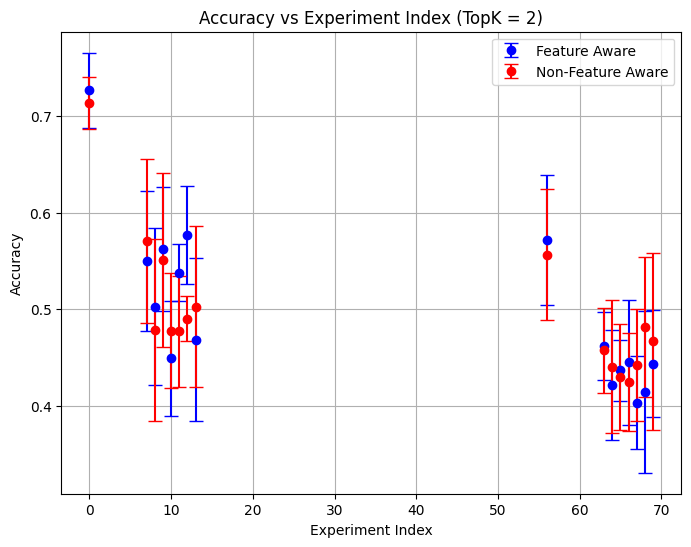

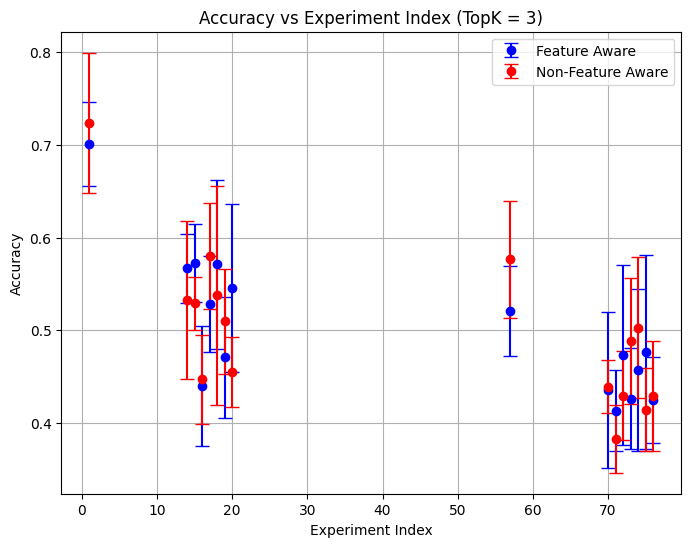

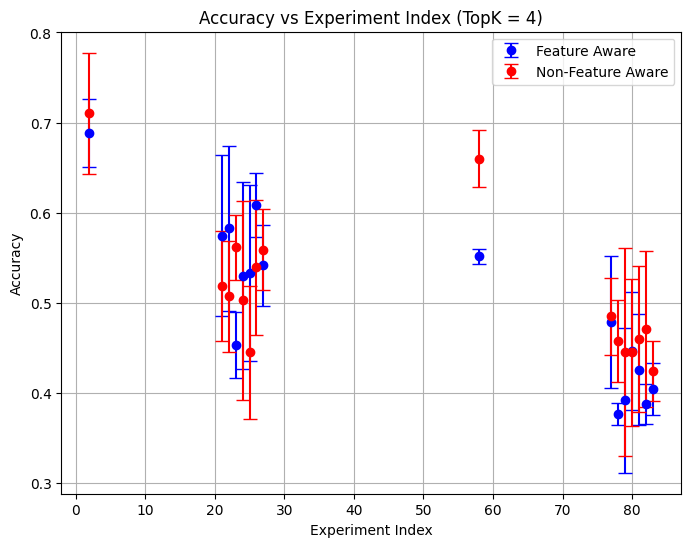

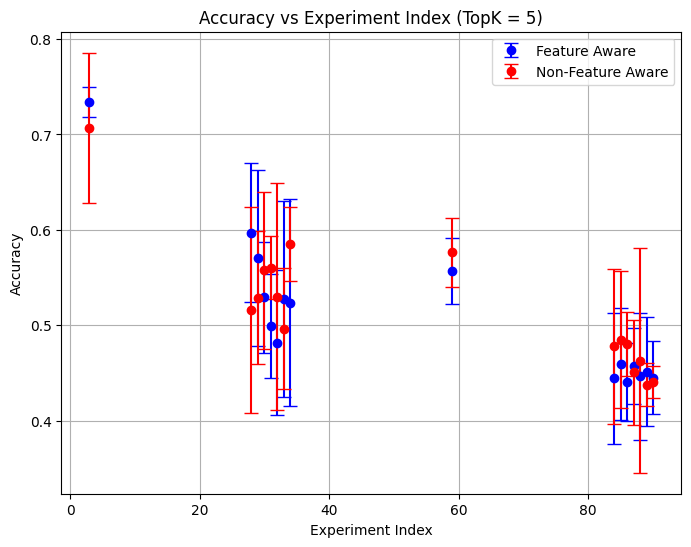

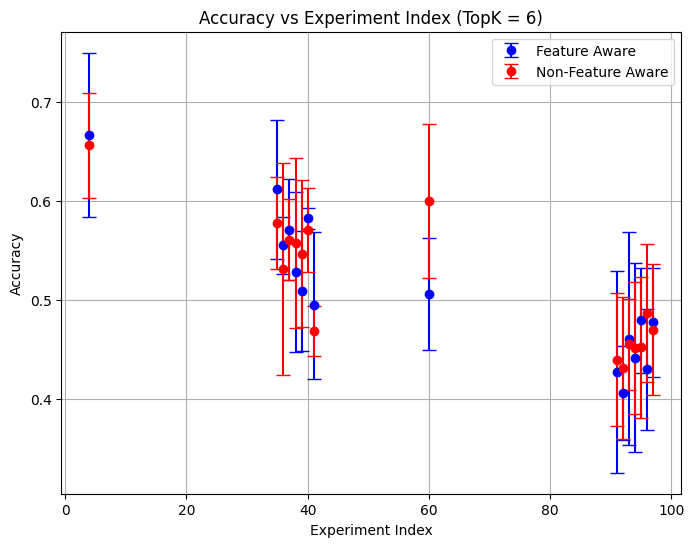

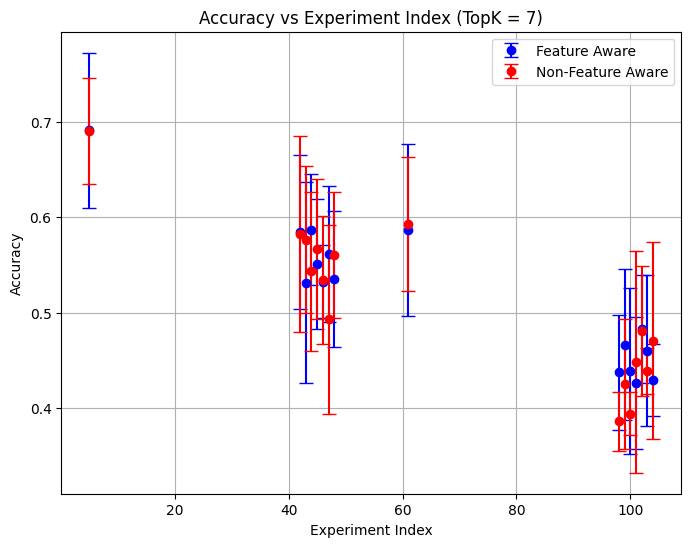

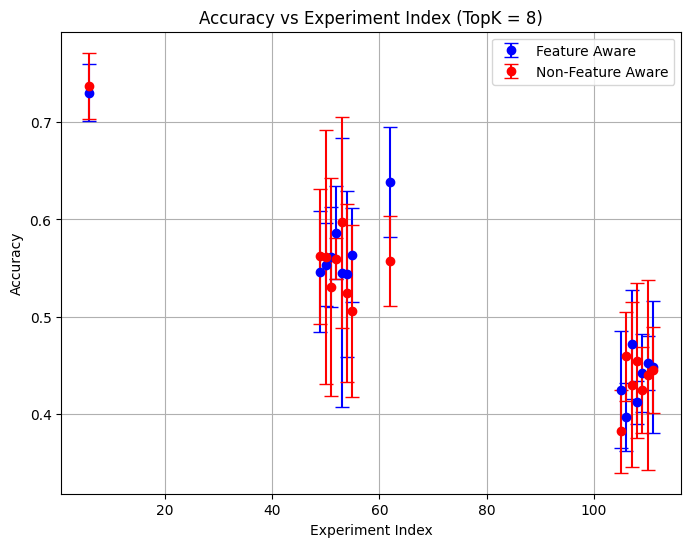

In [20]:
import matplotlib.pyplot as plt

# Unique TopK values
topk_values = sorted(df["TopK"].unique())

# Loop through each TopK and plot separately
for topk in topk_values:
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot

    # Filter data for current TopK
    topk_df = df[df["TopK"] == topk]
    feature_aware_df = topk_df[topk_df["Feature_Aware"] == True]
    non_feature_aware_df = topk_df[topk_df["Feature_Aware"] == False]

    # Plot feature-aware results
    plt.errorbar(feature_aware_df["index"] -112, feature_aware_df["Accuracy"], 
                 yerr=feature_aware_df["Accuracy_Std"], fmt='o', capsize=5, 
                 label="Feature Aware", color="blue")

    # Plot non-feature-aware results
    plt.errorbar(non_feature_aware_df["index"], non_feature_aware_df["Accuracy"], 
                 yerr=non_feature_aware_df["Accuracy_Std"], fmt='o', capsize=5, 
                 label="Non-Feature Aware", color="red")

    # Labels & title
    plt.xlabel("Experiment Index")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs Experiment Index (TopK = {topk})")
    plt.legend()
    plt.grid(True)

    # Show the plot independently
    plt.show()


In [ ]:
df